In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, confusion_matrix

In [2]:
# LOAD DATA & MODEL
# Load the OOF predictions (Log-space predictions from base models)
df_oof = pd.read_csv('oof_predictions.csv')

# Load the trained Meta-Learner
meta_model = joblib.load('final_lasso_meta_model.pkl')

# GENERATE STACKED PREDICTIONS
# 1. Get base model predictions
X_meta = df_oof[['pred_cat', 'pred_krr', 'pred_mlp']].values

# 2. Predict using the Lasso Meta-Learner (still in Log Space)
log_pred_stack = meta_model.predict(X_meta)

# 3. Inverse Transform to get eV (Physics Units)
# True Values
y_true_ev = np.expm1(df_oof['true_target'])
# Predicted Values
y_pred_ev = np.expm1(log_pred_stack)

# Clean up: Clip negative predictions to 0 (physics constraint)
y_pred_ev = np.maximum(y_pred_ev, 0)

In [3]:
# 3. REGRESSION METRICS (MAE, RMSE)
# ==========================================
mae = mean_absolute_error(y_true_ev, y_pred_ev)
rmse = np.sqrt(mean_squared_error(y_true_ev, y_pred_ev))
r2 = r2_score(y_true_ev, y_pred_ev)

print("--- Regression Performance (Band Gap in eV) ---")
print(f"MAE  : {mae:.4f} eV")
print(f"RMSE : {rmse:.4f} eV")
print(f"R2   : {r2:.4f}")

--- Regression Performance (Band Gap in eV) ---
MAE  : 0.4061 eV
RMSE : 0.8010 eV
R2   : 0.6927


In [4]:
# 4. CLASSIFICATION METRICS (F1 Score)
# ==========================================
# "Metal Classifier" Check
# In materials science, Bandgap < 0.01 eV is effectively a metal.
threshold = 0.01

# Convert continuous regression to binary classes (0 = Metal, 1 = Semiconductor)
true_class = (y_true_ev > threshold).astype(int)
pred_class = (y_pred_ev > threshold).astype(int)

f1 = f1_score(true_class, pred_class)
conf_mat = confusion_matrix(true_class, pred_class)

print("\n--- Classification Performance (Metal vs. Non-Metal) ---")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_mat) 
print("(Row=True, Col=Pred | [0,0]=True Metal, [1,1]=True Semi)")


--- Classification Performance (Metal vs. Non-Metal) ---
F1 Score: 0.7680
Confusion Matrix:
[[1179 1271]
 [  19 2135]]
(Row=True, Col=Pred | [0,0]=True Metal, [1,1]=True Semi)


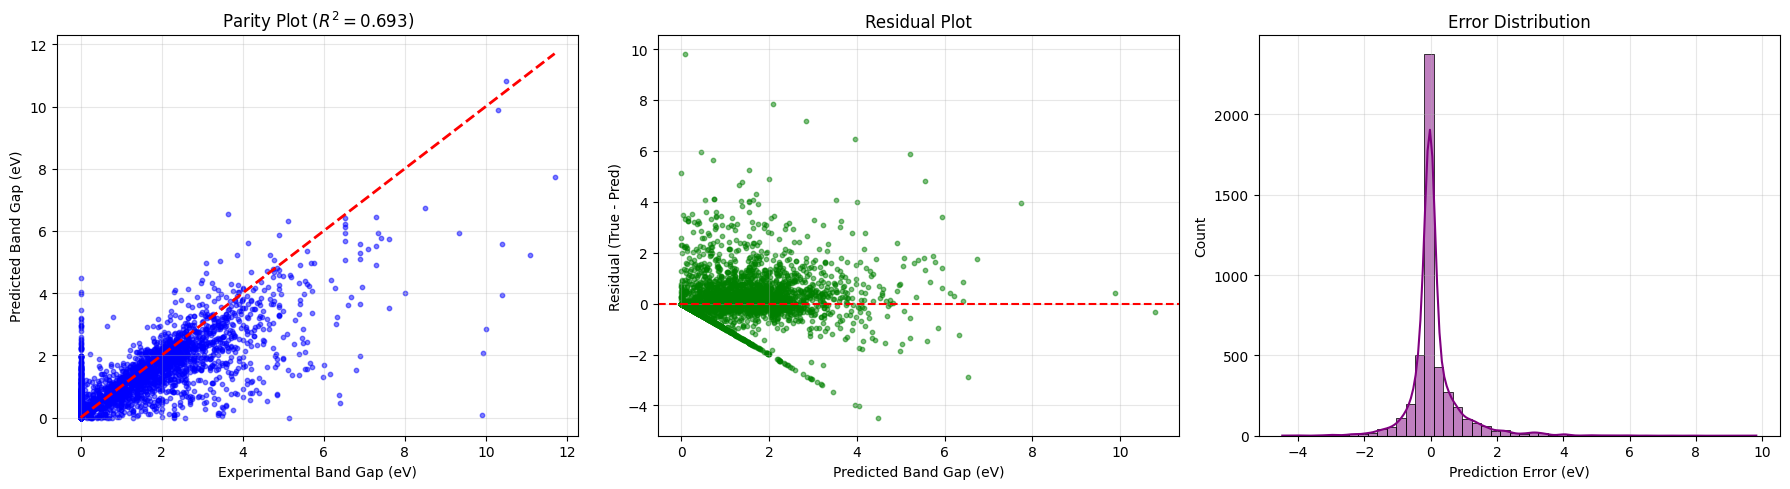

In [5]:
# 5. VISUALIZATION
# ==========================================
plt.figure(figsize=(18, 5))

# Plot A: Predicted vs Actual
plt.subplot(1, 3, 1)
plt.scatter(y_true_ev, y_pred_ev, alpha=0.5, s=10, color='blue')
plt.plot([0, y_true_ev.max()], [0, y_true_ev.max()], 'r--', lw=2) # Identity line
plt.xlabel("Experimental Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title(f"Parity Plot ($R^2={r2:.3f}$)")
plt.grid(True, alpha=0.3)

# Plot B: Residuals
residuals = y_true_ev - y_pred_ev
plt.subplot(1, 3, 2)
plt.scatter(y_pred_ev, residuals, alpha=0.5, s=10, color='green')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Band Gap (eV)")
plt.ylabel("Residual (True - Pred)")
plt.title("Residual Plot")
plt.grid(True, alpha=0.3)

# Plot C: Error Distribution
plt.subplot(1, 3, 3)
sns.histplot(residuals, bins=50, kde=True, color='purple')
plt.xlabel("Prediction Error (eV)")
plt.title("Error Distribution")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()